In [1]:
import networkx as nx
import gurobipy as gb
import numpy as np
from itertools import combinations
import math
import statistics

In [2]:
# use simplex for solving relaxation
gb.setParam('Method', 0)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-11
Set parameter Method to value 0


In [3]:
def draw_graph(G, labels=None):
    nx.draw(
        G,
        labels,
        with_labels=True, 
        # font_color="black", 
        font_size=10, 
        node_size=1000
    )

# Modeling function

In [4]:
def polygon_cover(G,dist):
    """Solve IP for minimum length polygon cover problem defined by A2 Q3 IP"""

    model = gb.Model("polygon cover")

    # 1. Create LP variables: create x_uv from two nodes u,v
    x = model.addVars(
        G.edges(),
        lb=0.0,
        ub=1.0,
        # obj=dist,
        vtype=gb.GRB.BINARY,
        name='x'
    )

    # 2. Create LP constraints:  sum up all x_uv for each node u
    for u in G.nodes():
        # print(u)
        sum_u = 0
        for e in G.edges():
            if u in e:
                # print(x[e].getAttr("Obj"))
                sum_u += x[e]
        model.addConstr(
            sum_u == 2
        )
    model.update()

    # 3. Create LP objective: sum dist_uv*x_uv
    mul = []
    i = 0
    for e in G.edges():
        mul.append(dist[i]*x[e])
        # print(mul[i])
        i += 1
    
    model.setObjective(
        gb.quicksum(mul),
        gb.GRB.MINIMIZE
    )

    # model.ModelSense = gb.GRB.MINIMIZE

    # 7. Optimize
    model.optimize()

    return model


# Evaluation

## Create a Graph in the Unit Square and populate with points 2^n, where n >=2


In [5]:
#  Create vertices and edges for the graph
n = 2
points = np.random.uniform(low=0,high=1,size=(2**(n),2))
nodes = [tuple([x[0], x[1]]) for x in points]
edges = combinations(nodes, 2)
# edges_weighted = [(a,b,1) for (a,b) in edges]
print(nodes)

P = nx.Graph()
P.add_nodes_from(nodes)
P.add_edges_from(edges)
distances = []
for e in nx.edges(P):
    # print([e,math.dist(e[0],e[1])])
    distances.append(math.dist(e[0],e[1]))
# print(distances)
print(P)
print(nx.edges(P))

[(0.42365742135881534, 0.31955940794885584), (0.836456590808306, 0.810121570587596), (0.3517724813576846, 0.2988368584713108), (0.025118895877954794, 0.6167708429683781)]
Graph with 4 nodes and 6 edges
[((0.42365742135881534, 0.31955940794885584), (0.836456590808306, 0.810121570587596)), ((0.42365742135881534, 0.31955940794885584), (0.3517724813576846, 0.2988368584713108)), ((0.42365742135881534, 0.31955940794885584), (0.025118895877954794, 0.6167708429683781)), ((0.836456590808306, 0.810121570587596), (0.3517724813576846, 0.2988368584713108)), ((0.836456590808306, 0.810121570587596), (0.025118895877954794, 0.6167708429683781)), ((0.3517724813576846, 0.2988368584713108), (0.025118895877954794, 0.6167708429683781))]


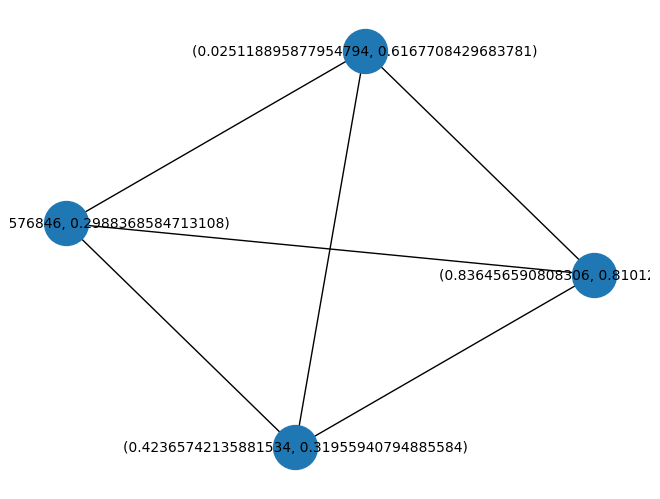

In [6]:
draw_graph(P)

In [7]:
m = polygon_cover(P,distances)

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 4 rows, 6 columns and 12 nonzeros
Model fingerprint: 0x5ba60bd1
Variable types: 0 continuous, 6 integer (6 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e-02, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Presolve removed 4 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 16 available processors)

Solution count 1: 2.00584 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.005839767266e+00, best bound 2.005839767266e+00, gap 0.0000%


In [8]:
m.printAttr('X')


    Variable            X 
-------------------------
x[(0.42365742135881534, 0.31955940794885584),(0.836456590808306, 0.810121570587596)]            1 
x[(0.42365742135881534, 0.31955940794885584),(0.3517724813576846, 0.2988368584713108)]            1 
x[(0.836456590808306, 0.810121570587596),(0.025118895877954794, 0.6167708429683781)]            1 
x[(0.3517724813576846, 0.2988368584713108),(0.025118895877954794, 0.6167708429683781)]            1 


In [9]:
val = m.getAttr("ObjVal")
print(val)

2.0058397672655186


## Function to sample multiple times (num_samples)

In [10]:
def sample_polygon_cover(n, num_samples):
    output = []
    
    for i in range(0, num_samples):
        # Create Points, Nodes and Edges for graph
        points = np.random.uniform(low=0,high=1,size=(2**(n),2))
        nodes = [tuple([x[0], x[1]]) for x in points]
        edges = combinations(nodes, 2)
        
        # Create graph and add nodes and edges
        poly_cover = nx.Graph()
        poly_cover.add_nodes_from(nodes)
        poly_cover.add_edges_from(edges)
        dist = []
        for e in nx.edges(poly_cover):
            # print([e,math.dist(e[0],e[1])])
            dist.append(math.dist(e[0],e[1]))

        print(poly_cover)

        # Create Model
        m = polygon_cover(poly_cover,dist)

        # m.printAttr("x")
        # m.printAttr("Runtime")

        output.append(m.getAttr("ObjVal"))

    return output   

In [11]:
num_samples = 16
samples = []
sample_mean = []

In [12]:
# Sampling with n = 2^2
samp_n_2 = sample_polygon_cover(2, num_samples)
print(samp_n_2)
samples.append(samp_n_2)
sample_mean.append(statistics.mean(samp_n_2))

Graph with 4 nodes and 6 edges
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 4 rows, 6 columns and 12 nonzeros
Model fingerprint: 0x5ead87dc
Variable types: 0 continuous, 6 integer (6 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-01, 9e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Presolve removed 4 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 16 available processors)

Solution count 1: 1.93403 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.934033424440e+00, best bound 1.934033424440e+00, gap 0.0000%
Graph with 4 nodes and 6 edges
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Opt

In [13]:
# Sampling with n = 2^3
samp_n_3 = sample_polygon_cover(3, num_samples)
print(samp_n_3)
samples.append(samp_n_3)
sample_mean.append(statistics.mean(samp_n_3))

Graph with 8 nodes and 28 edges
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 8 rows, 28 columns and 56 nonzeros
Model fingerprint: 0xdadc14e5
Variable types: 0 continuous, 28 integer (28 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e-02, 9e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Found heuristic solution: objective 5.0005651
Presolve time: 0.00s
Presolved: 8 rows, 28 columns, 56 nonzeros
Variable types: 0 continuous, 28 integer (28 binary)

Root relaxation: objective 2.686997e+00, 10 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       2.6869966    2.68700  0.00%     -    0s

Explored 1 nodes (10 simplex iterations) in 0.02 seconds

In [14]:
# Sampling with n = 2^4
samp_n_4 = sample_polygon_cover(4, num_samples)
print(samp_n_4)
samples.append(samp_n_4)
sample_mean.append(statistics.mean(samp_n_4))

Graph with 16 nodes and 120 edges
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 16 rows, 120 columns and 240 nonzeros
Model fingerprint: 0xcd87c178
Variable types: 0 continuous, 120 integer (120 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Found heuristic solution: objective 7.8718931
Presolve time: 0.00s
Presolved: 16 rows, 120 columns, 240 nonzeros
Variable types: 0 continuous, 120 integer (120 binary)

Root relaxation: objective 2.882256e+00, 39 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       2.8822561    2.88226  0.00%     -    0s

Explored 1 nodes (39 simplex iterations) in 

In [15]:
# Sampling with n = 2^5
samp_n_5 = sample_polygon_cover(5, num_samples)
print(samp_n_5)
samples.append(samp_n_5)
sample_mean.append(statistics.mean(samp_n_5))

Graph with 32 nodes and 496 edges
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 32 rows, 496 columns and 992 nonzeros
Model fingerprint: 0xb7b9668e
Variable types: 0 continuous, 496 integer (496 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Found heuristic solution: objective 17.5270195
Presolve time: 0.00s
Presolved: 32 rows, 496 columns, 992 nonzeros
Variable types: 0 continuous, 496 integer (496 binary)

Root relaxation: objective 4.636445e+00, 84 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       4.6364448    4.63644  0.00%     -    0s

Explored 1 nodes (84 simplex iterations) in

In [16]:
# Sampling with n = 2^6
samp_n_6 = sample_polygon_cover(6, num_samples)
print(samp_n_6)
samples.append(samp_n_6)
sample_mean.append(statistics.mean(samp_n_6))

Graph with 64 nodes and 2016 edges
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 64 rows, 2016 columns and 4032 nonzeros
Model fingerprint: 0x51eddd43
Variable types: 0 continuous, 2016 integer (2016 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Found heuristic solution: objective 36.1936827
Presolve time: 0.00s
Presolved: 64 rows, 2016 columns, 4032 nonzeros
Variable types: 0 continuous, 2016 integer (2016 binary)

Root relaxation: objective 5.997513e+00, 313 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    5.99751    0   12   36.19368    5.99751  83.4%     -    0s
H    0     0                      

In [17]:
# Sampling with n = 2^7
samp_n_7 = sample_polygon_cover(7, num_samples)
print(samp_n_7)
samples.append(samp_n_7)
sample_mean.append(statistics.mean(samp_n_7))

Graph with 128 nodes and 8128 edges
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 128 rows, 8128 columns and 16256 nonzeros
Model fingerprint: 0xb66ee0b3
Variable types: 0 continuous, 8128 integer (8128 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-03, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Found heuristic solution: objective 64.1682022
Presolve time: 0.01s
Presolved: 128 rows, 8128 columns, 16256 nonzeros
Variable types: 0 continuous, 8128 integer (8128 binary)

Root relaxation: objective 8.397203e+00, 1020 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    8.39720    0   14   64.16820    8.39720  86.9%     -    0s
H    0     0                

In [18]:
# Sampling with n = 2^8
samp_n_8 = sample_polygon_cover(8, num_samples)
print(samp_n_8)
samples.append(samp_n_8)
sample_mean.append(statistics.mean(samp_n_8))

Graph with 256 nodes and 32640 edges
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 256 rows, 32640 columns and 65280 nonzeros
Model fingerprint: 0x8623debe
Variable types: 0 continuous, 32640 integer (32640 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-03, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Found heuristic solution: objective 135.7423398
Presolve time: 0.03s
Presolved: 256 rows, 32640 columns, 65280 nonzeros
Variable types: 0 continuous, 32640 integer (32640 binary)

Root relaxation: objective 1.155695e+01, 2619 iterations, 0.02 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   11.55695    0   52  135.74234   11.55695  91.5%     -    0s
H    0     0        

In [19]:
# Sampling with n = 2^9
samp_n_9 = sample_polygon_cover(9, num_samples)
print(samp_n_9)
samples.append(samp_n_9)
sample_mean.append(statistics.mean(samp_n_9))

Graph with 512 nodes and 130816 edges
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 512 rows, 130816 columns and 261632 nonzeros
Model fingerprint: 0x1fe24b18
Variable types: 0 continuous, 130816 integer (130816 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e-04, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Found heuristic solution: objective 272.8617006
Presolve time: 0.20s
Presolved: 512 rows, 130816 columns, 261632 nonzeros
Variable types: 0 continuous, 130816 integer (130816 binary)

Root relaxation: objective 1.564074e+01, 10304 iterations, 0.13 seconds (0.11 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   15.64074    0   66  272.86170   15.64074  94.3%     -    0s
H    0    

## Data storing, plotting and output

In [20]:
print(samples)
print(sample_mean)

[[1.9340334244398074, 2.2691277619288575, 1.6473627610220736, 1.723384721808098, 1.3917166834214298, 1.647757966831589, 1.7515118722650647, 1.9444061809802002, 2.0398305024904837, 1.7507987879957634, 2.2111157289361043, 2.3550244713490396, 2.4583543594728448, 2.326776480155908, 1.830731630253538, 1.2362462759177089], [2.686996592226521, 2.874399906721112, 2.056262379473732, 2.5834288840742383, 2.7251181033097236, 1.2399155966726918, 2.1631998406694217, 2.2395614916908895, 2.664625860507053, 2.1930965094612547, 2.0404771440399108, 2.7000559419038193, 2.3020356833988003, 2.692353828321766, 2.4258123325733667, 2.227639361127809], [2.882256118896773, 3.2216009028405383, 3.5116605113331882, 4.016937695327289, 2.843383829181893, 3.049717493961497, 3.8074844485124513, 3.611313883948029, 3.5058452468484607, 3.266458211286974, 2.943254533524285, 3.177955183945121, 3.2765832755259368, 2.827143383760078, 3.15786986536006, 3.4450190734930404], [4.6364447886419535, 4.154133985489963, 4.773891335652

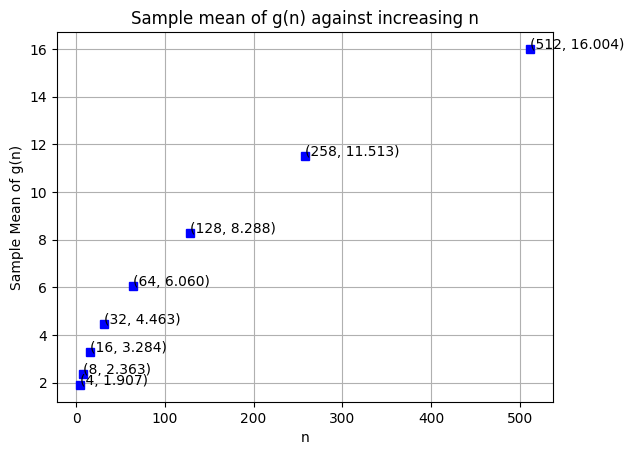

In [63]:
import matplotlib.pyplot as plt
x_points=[4, 8, 16, 32, 64, 128, 258, 512]
x_log_points = [2,3,4,5,6,7,8,9]

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(x_points, sample_mean, 'bs')

plt.ylabel('Sample Mean of g(n)')
plt.xlabel('n')
plt.title("Sample mean of g(n) against increasing n")
for i in zip(x_points, sample_mean):
    ax.annotate('(%i, %.3f)' % i, xy=i, textcoords='data')
plt.grid()
plt.show()

In [60]:
# Export data

import pandas as pd
dict = {
    "sample 1": [x[0] for x in samples],
    "sample 2": [x[1] for x in samples],
    "sample 3": [x[2] for x in samples],
    "sample 4": [x[3] for x in samples],
    "sample 5": [x[4] for x in samples],
    "sample 6": [x[5] for x in samples],
    "sample 7": [x[6] for x in samples],
    "sample 8": [x[7] for x in samples],
    "sample 9": [x[8] for x in samples],
    "sample 10": [x[9] for x in samples],
    "sample 11": [x[10] for x in samples],
    "sample 12": [x[11] for x in samples],
    "sample 13": [x[12] for x in samples],
    "sample 14": [x[13] for x in samples],
    "sample 15": [x[14] for x in samples],
    "sample 16": [x[15] for x in samples],
    "sample_mean": sample_mean
}

# Create dataframe
df = pd.DataFrame(dict, index = ["n = 2^2", "n = 2^3", "n = 2^4", "n = 2^5", "n = 2^6", "n = 2^7", "n = 2^8", "n = 2^9"])

# Save data frame to csv
df.to_csv('./Q4 Sampling.csv', encoding='utf-8', index=True)

print(df)

          sample 1   sample 2   sample 3   sample 4   sample 5   sample 6  \
n = 2^2   1.934033   2.269128   1.647363   1.723385   1.391717   1.647758   
n = 2^3   2.686997   2.874400   2.056262   2.583429   2.725118   1.239916   
n = 2^4   2.882256   3.221601   3.511661   4.016938   2.843384   3.049717   
n = 2^5   4.636445   4.154134   4.773891   4.395459   4.800307   4.570862   
n = 2^6   6.120690   5.732868   5.797490   6.370011   6.288243   5.856965   
n = 2^7   8.467903   8.251730   8.174874   7.797307   7.959541   8.310584   
n = 2^8  11.685445  12.005028  11.503033  11.621578  11.527080  11.180481   
n = 2^9  15.740780  16.476886  15.939822  16.252465  16.049445  16.092212   

          sample 7   sample 8   sample 9  sample 10  sample 11  sample 12  \
n = 2^2   1.751512   1.944406   2.039831   1.750799   2.211116   2.355024   
n = 2^3   2.163200   2.239561   2.664626   2.193097   2.040477   2.700056   
n = 2^4   3.807484   3.611314   3.505845   3.266458   2.943255   3.177955  